In [1]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 2.9 MB/s eta 0:00:00


In [2]:
%%bash

# Download Example Data --------------------------------------------------------

rm -rf ./sample_data/

mkdir -p data

rm -f ./data/*

curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/data/pwm_seq_200bp_test_set.txt >./data/pwm_seq_200bp_test_set.txt
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/data/pwm_seq_200bp_valid_set.txt >./data/pwm_seq_200bp_valid_set.txt
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/data/pwm_seq_200bp_train_set.txt >./data/pwm_seq_200bp_train_set.txt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198k  100  198k    0     0   436k      0 --:--:-- --:--:-- --:--:--  435k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  198k  100  198k    0     0   485k      0 --:--:-- --:--:-- --:--:--  487k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7533k  100 7533k    0     0  7725k      0 --:--:-- --:--:-- --:--:-- 7726k


In [3]:
%%bash

# Create some directories and download helper scripts for later ----------------
mkdir -p helper visualize

curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/helper/functions_for_motif_plotting.R >./helper/functions_for_motif_plotting.R
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/helper/plot_sequence_kernel_weights_per_dir.R >./helper/plot_sequence_kernel_weights_per_dir.R
curl https://raw.githubusercontent.com/rschwess/tutorial_dl_for_genomics/master/helper/plot_sequence_kernel_icms_per_dir.R >./helper/plot_sequence_kernel_icms_per_dir.R


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18139  100 18139    0     0  54072      0 --:--:-- --:--:-- --:--:-- 54146
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1512  100  1512    0     0   5630      0 --:--:-- --:--:-- --:--:--  5620
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1510  100  1510    0     0   3636      0 --:--:-- --:--:-- --:--:--  3638


In [4]:
%%bash

# Check Data Layout ###########################

# check lines per set
echo "Numbers:"
wc -l ./data/pwm*

# check data format
echo -ne "\nFormat\n"
head -n 3 ./data/pwm_seq_200bp_test_set.txt

# check class representation
echo -ne "\nClass Representations:\n"

echo -ne "\nTraining:\n"
cut -f 1 ./data/pwm_seq_200bp_train_set.txt | sort | uniq -c
echo -ne "\nTest:\n"
cut -f 1 ./data/pwm_seq_200bp_test_set.txt | sort | uniq -c
echo -ne "\nValidation:\n"
cut -f 1 ./data/pwm_seq_200bp_valid_set.txt | sort | uniq -c



Numbers:
   1000 ./data/pwm_seq_200bp_test_set.txt
  38000 ./data/pwm_seq_200bp_train_set.txt
   1000 ./data/pwm_seq_200bp_valid_set.txt
  40000 total

Format
3	ATGGCTGATAATGACGATTGTACAGATGGTGGATGAGATTGCCTCGTCCCGGCAGCATTACCCCCTGGTGGCAACGGCCACCAGGGGGCAATAAATCTGTGTCTTATCTCCGAGACCAAACAATTCCACAGCCTCTTATACAGCACCGAATGGACCGCCCCCTGGTGGCCAGGTATCGTCGAGGGCTCAATTAAACTCCT
1	GCAGGCATTATGAGGTAATAAACTCAGCGCGTGTTGAGATAAGATTCTAAGCGGCGCGCGCGCGCGACCGCGAGAAGTGGAGATTAAGCGCGCTAATGGTGTGTCCGATAGTCACGTGTCCGCGCGGCGCGCGCCATGTATGTTCTGTTCTGCGCGCCGCGCTTTGCGCGCGCGCTTGGTATATAAAGCTGGGTTTTAAT
1	GGCGCGCCTGGCATTTCTTAGAGAGGCGCGCAATACAACGAGAATCACCTAGAAGCCGTGTCTGTTGCTTATCACCGTTCGCCTAGGCCGCACGGGCACGTGGGTCTCCCGTTCCCTCAATCCTAACAGAAGCGCGCTAAGTCGTCGTTGGCTCTCTTACTAGCAGCGCGCCTGTACTAACCCGGCACTCGGCGGTGGGC

Class Representations:

Training:
   9489 0
   9513 1
   9508 2
   9490 3

Test:
    268 0
    237 1
    243 2
    252 3

Validation:
    243 0
    250 1
    249 2
    258 3


In [5]:
pip install hmmlearn

In [6]:
import pandas as pd
import numpy as np
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [7]:
def encode_sequence(seq):
    return [nucleotide_map[nuc] for nuc in seq if nuc in nucleotide_map]

def load_data(filepath):
    data = pd.read_csv(filepath, sep="\t", header=None, names=["label", "sequence"])
    data["encoded"] = data["sequence"].apply(encode_sequence)
    return data

def train_hmm_per_label(train_data, n_states=3):
    label_hmms = {}
    for label in sorted(train_data['label'].unique()):
        label_data = train_data[train_data['label'] == label]
        sequences = label_data['encoded'].tolist()
        lengths = [len(seq) for seq in sequences]
        X = np.concatenate([np.array(seq) for seq in sequences]).reshape(-1, 1)

        model = hmm.MultinomialHMM(n_components=n_states, n_iter=100, tol=1e-4, random_state=42)
        model.fit(X, lengths)
        label_hmms[label] = model
    return label_hmms

def predict_labels(hmm_models, data):
    predictions = []
    for seq in data['encoded']:
        seq_array = np.array(seq).reshape(-1, 1)
        scores = {label: model.score(seq_array) for label, model in hmm_models.items()}
        pred_label = max(scores, key=scores.get)
        predictions.append(pred_label)
    return predictions

In [8]:

def evaluate(true_labels, pred_labels, set_name="Test"):
    print(f"\n--- {set_name} Set Evaluation ---")
    print("Accuracy:", accuracy_score(true_labels, pred_labels))
    print("Confusion Matrix:\n", confusion_matrix(true_labels, pred_labels))
    print("Classification Report:\n", classification_report(true_labels, pred_labels))


In [10]:
nucleotide_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

In [11]:

# Load data
train = load_data("/content/data/pwm_seq_200bp_train_set.txt")
test = load_data("/content/data/pwm_seq_200bp_test_set.txt")
valid = load_data("/content/data/pwm_seq_200bp_valid_set.txt")  # Ensure this file exists


In [12]:
# Train HMMs
hmm_models = train_hmm_per_label(train, n_states=6)


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


In [13]:
# Predict
test_preds = predict_labels(hmm_models, test)
valid_preds = predict_labels(hmm_models, valid)

In [14]:

# Evaluate
evaluate(test['label'], test_preds, "Test")
evaluate(valid['label'], valid_preds, "Validation")


--- Test Set Evaluation ---
Accuracy: 0.237
Confusion Matrix:
 [[  0 268   0   0]
 [  0 237   0   0]
 [  0 243   0   0]
 [  0 252   0   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       268
           1       0.24      1.00      0.38       237
           2       0.00      0.00      0.00       243
           3       0.00      0.00      0.00       252

    accuracy                           0.24      1000
   macro avg       0.06      0.25      0.10      1000
weighted avg       0.06      0.24      0.09      1000


--- Validation Set Evaluation ---
Accuracy: 0.25
Confusion Matrix:
 [[  0 243   0   0]
 [  0 250   0   0]
 [  0 249   0   0]
 [  0 258   0   0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       243
           1       0.25      1.00      0.40       250
           2       0.00      0.00      0.00       249
           3 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load sequences and labels
def load_data(filepath):
    sequences, labels = [], []
    with open(filepath, 'r') as f:
        for line in f:
            label, seq = line.strip().split('\t')
            sequences.append(seq)
            labels.append(int(label))
    return sequences, labels

def one_hot_encode(seq, seq_len=200):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    one_hot = np.zeros((seq_len, 4))
    for i, base in enumerate(seq):
        if base in mapping:
            one_hot[i, mapping[base]] = 1
    return one_hot

train_sequences, train_labels = load_data("/content/data/pwm_seq_200bp_train_set.txt")
test_sequences, test_labels = load_data("/content/data/pwm_seq_200bp_test_set.txt")

X_train = np.array([one_hot_encode(seq) for seq in train_sequences])
X_test = np.array([one_hot_encode(seq) for seq in test_sequences])
y_train = to_categorical(train_labels, num_classes=4)
y_test = to_categorical(test_labels, num_classes=4)

# CNN Model
model = Sequential([
    Conv1D(64, 10, activation='relu', input_shape=(200, 4)),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),
    Conv1D(128, 10, activation='relu'),
    MaxPooling1D(pool_size=3),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1)

# Evaluate
preds = model.predict(X_test)
y_pred_cnn = np.argmax(preds, axis=1)
y_true_cnn = np.argmax(y_test, axis=1)
print("\nCNN Classification Report:\n")
print(classification_report(y_true_cnn, y_pred_cnn))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 47s 158ms/step - accuracy: 0.6110 - loss: 0.8289 - val_accuracy: 0.8534 - val_loss: 0.3315
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 77s 138ms/step - accuracy: 0.8835 - loss: 0.2854 - val_accuracy: 0.9153 - val_loss: 0.2060
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 139ms/step - accuracy: 0.9380 - loss: 0.1606 - val_accuracy: 0.9734 - val_loss: 0.0838
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 40s 134ms/step - accuracy: 0.9629 - loss: 0.1041 - val_accuracy: 0.9726 - val_loss: 0.0749
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 42s 137ms/step - accuracy: 0.9691 - loss: 0.0840 - val_accuracy: 0.9821 - val_loss: 0.0590
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 40s 132ms/step - accuracy: 0.9748 - loss: 0.0703 - val_accuracy: 0.9850 - val_loss: 0.0465
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 41s 134ms/step - accuracy: 0.9809 - loss: 0.0556 - val_accuracy: 0.9834 - val_loss: 0.0486
Epoch 8/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 42s 136ms/step - accuracy: 0.9826 - loss: 0

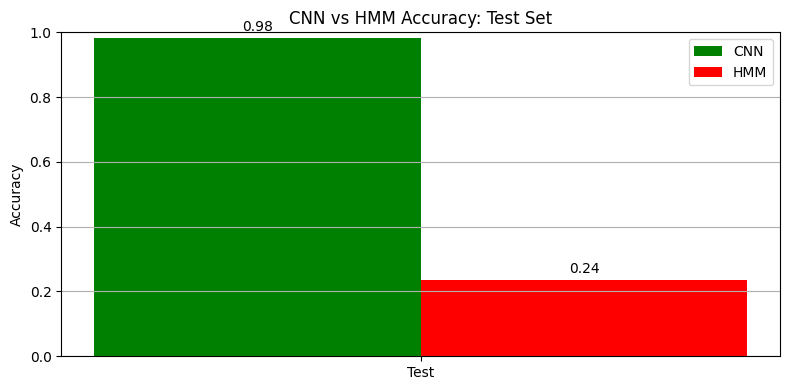

In [22]:
#comparing model performance
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# HMM Accuracies (based on test and valid dataframes)
hmm_test_accuracy = accuracy_score(test['label'], test_preds)
hmm_valid_accuracy = accuracy_score(valid['label'], valid_preds)

# CNN Accuracies (from earlier code)
cnn_test_accuracy = accuracy_score(y_true_cnn, y_pred_cnn)

# Plot
labels = ['Test']
x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar([i - width/2 for i in x], [cnn_test_accuracy], width=width, label='CNN', color='green')
plt.bar([i + width/2 for i in x], [hmm_test_accuracy], width=width, label='HMM', color='red')

plt.xticks(x, labels)
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('CNN vs HMM Accuracy: Test Set')
plt.legend()

# Annotate
for i, (c_acc, h_acc) in enumerate(zip([cnn_test_accuracy], [hmm_test_accuracy])):
    plt.text(i - width/2, c_acc + 0.02, f'{c_acc:.2f}', ha='center')
    plt.text(i + width/2, h_acc + 0.02, f'{h_acc:.2f}', ha='center')

plt.grid(axis='y')
plt.tight_layout()
plt.show()
